Text(0, 0.5, 'PGA (g)')

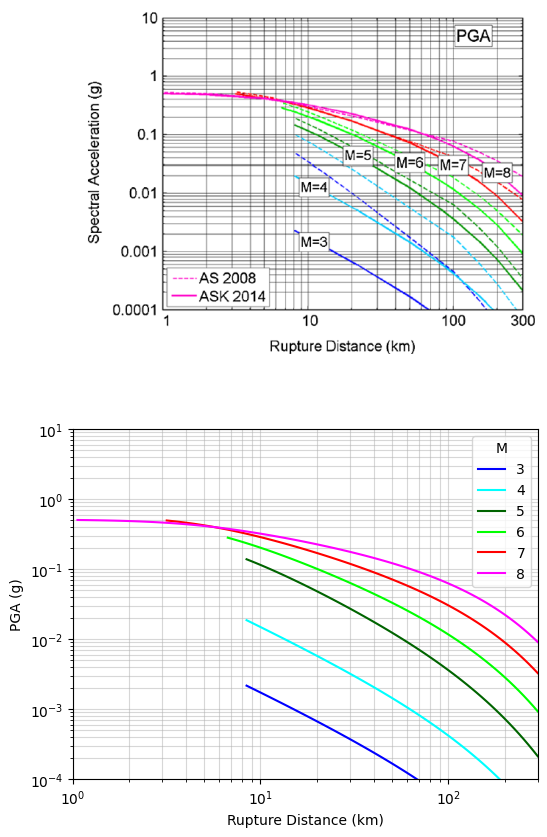

In [1]:
# Reproduce Fig. 8 from ASK model
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from ucla_plha.ground_motion_models import ask14

rrup_vec = np.logspace(0, np.log10(300), 100)
m_vec = np.asarray([3, 4, 5, 6, 7, 8])
rrup_lim = np.asarray([8, 8, 8, 6.5, 3.0, 1.0])
ztor_vec = np.asarray([8, 8, 8, 6.5, 3.0, 0.0])
colors = np.asarray(['blue', 'cyan', 'darkgreen', 'lime', 'red', 'magenta'])
rrup = np.empty(len(m_vec) * len(rrup_vec), dtype=float)
m = np.empty(len(m_vec) * len(rrup_vec), dtype=float)
ztor = np.empty(len(m_vec) * len(rrup_vec), dtype=float)
I = 0
for i in range(len(m_vec)):
    for j in range(len(rrup_vec)):
        m[I] = m_vec[i]
        rrup[I] = rrup_vec[j]
        ztor[I] = ztor_vec[i]
        I += 1

vs30 = 760
dip = np.full(len(m), 90.0)
rx = np.full(len(m), 0.0)
rx1 = np.full(len(m), 0.0)
ry0 = np.full(len(m), 0.0)
fault_type = np.full(len(m), 3)
measured_vs30 = True

mu_ln, sigma_ln = ask14.get_im(vs30,rrup,rx,rx1,ry0,m,fault_type,measured_vs30,dip,ztor)
pga = np.exp(mu_ln)

fig, ax = plt.subplots(nrows=2, figsize=(6, 10))

image = mpimg.imread('ask14_validation.png')
ax[0].imshow(image)
ax[0].axis('off')
for i, m_val in enumerate(m_vec):
    ax[1].plot(rrup[(m == m_val) & (rrup > rrup_lim[i])], pga[(m == m_val) & (rrup > rrup_lim[i])], label=str(m_val), c=colors[i])
ax[1].set_yscale('log')
ax[1].set_xscale('log')
ax[1].set_ylim(0.0001, 10)
ax[1].set_xlim(1, 300)
ax[1].legend(title='M')
ax[1].grid(True, alpha=0.5, which='both')
ax[1].set_xlabel('Rupture Distance (km)')
ax[1].set_ylabel('PGA (g)')

Text(0, 0.5, 'PGA (g)')

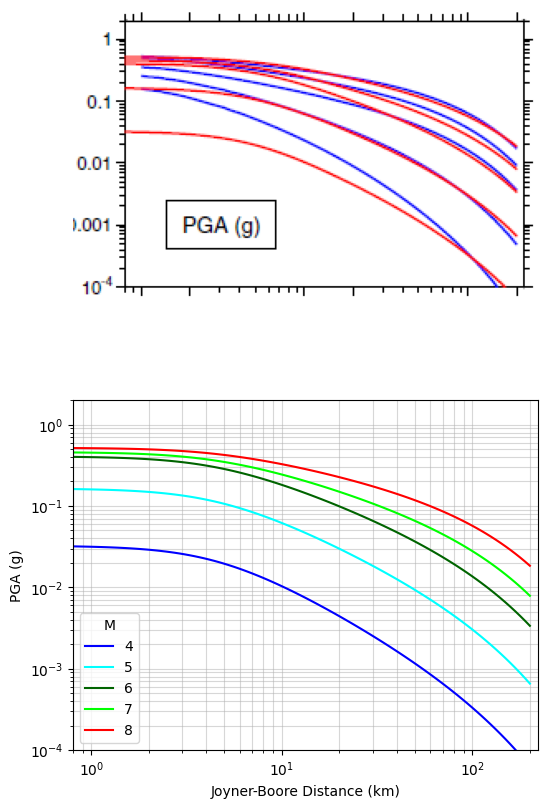

In [2]:
# Reproduce PGA part of Fig. 7 from BSSA14 model
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from ucla_plha.ground_motion_models import bssa14

rjb_vec = np.logspace(np.log(0.8), np.log10(200), 100)
m_vec = np.asarray([4, 5, 6, 7, 8])
rjb = np.empty(len(m_vec) * len(rjb_vec), dtype=float)
m = np.empty(len(m_vec) * len(rjb_vec), dtype=float)
I = 0
for i in range(len(m_vec)):
    for j in range(len(rjb_vec)):
        m[I] = m_vec[i]
        rjb[I] = rjb_vec[j]
        I += 1

vs30 = 760
fault_type = np.full(len(m), 3)

mu_ln, sigma_ln = bssa14.get_im(vs30,rjb,m,fault_type)
pga = np.exp(mu_ln)

fig, ax = plt.subplots(nrows=2, figsize=(6, 10))

image = mpimg.imread('bssa14_validation.png')
ax[0].imshow(image)
ax[0].axis('off')
for i, m_val in enumerate(m_vec):
    ax[1].plot(rjb[m == m_val], pga[m == m_val], label=str(m_val), c=colors[i])
ax[1].set_yscale('log')
ax[1].set_xscale('log')
ax[1].set_ylim(0.0001, 2)
ax[1].set_xlim(0.8, 220)
ax[1].legend(title='M')
ax[1].grid(True, alpha=0.5, which='both')
ax[1].set_xlabel('Joyner-Boore Distance (km)')
ax[1].set_ylabel('PGA (g)')

Text(0, 0.5, 'PGA (g)')

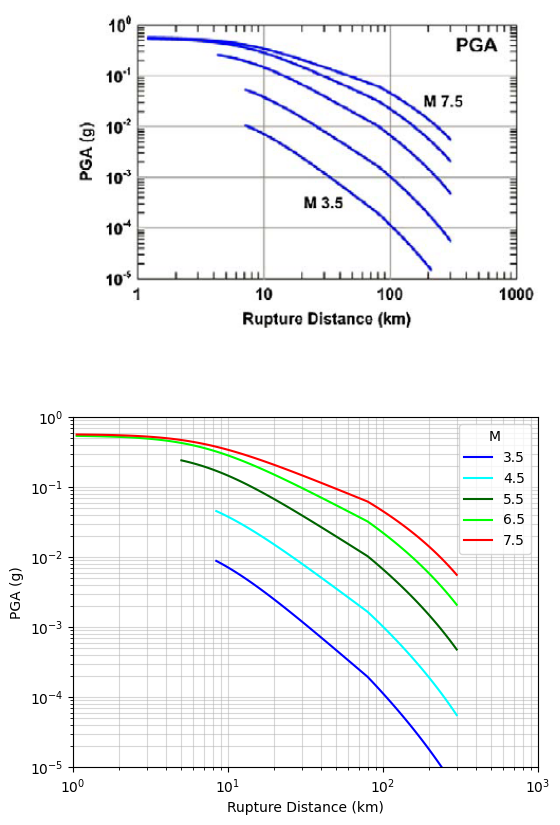

In [3]:
# Reproduce Fig. 6 from CB14 model
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from ucla_plha.ground_motion_models import cb14

rrup_vec = np.logspace(0, np.log10(300), 100)
m_vec = np.asarray([3.5, 4.5, 5.5, 6.5, 7.5])
rrup_lim = np.asarray([8, 8, 5, 1.0, 1.0])
ztor_vec = np.asarray([8, 8, 5, 0.0, 0.0])
colors = np.asarray(['blue', 'cyan', 'darkgreen', 'lime', 'red', 'magenta'])
rrup = np.empty(len(m_vec) * len(rrup_vec), dtype=float)
m = np.empty(len(m_vec) * len(rrup_vec), dtype=float)
ztor = np.empty(len(m_vec) * len(rrup_vec), dtype=float)
zhyp = np.empty(len(m_vec) * len(rrup_vec), dtype=float)
zbor = np.empty(len(m_vec) * len(rrup_vec), dtype=float)
I = 0
vs30 = 760
dip = np.full(len(m), 90.0)
rx = np.full(len(m), 0.0)
rx1 = np.full(len(m), 0.0)
fault_type = np.full(len(m), 3)
for i in range(len(m_vec)):
    for j in range(len(rrup_vec)):
        m[I] = m_vec[i]
        rrup[I] = rrup_vec[j]
        ztor[I] = np.max([2.673 - 1.136 * np.max([m[I] - 4.970, 0]), 0])**2
        W = np.sqrt(10 ** ((m[I] - 4.07) / 0.98))
        zhyp[I] = ztor[I] - 0.5 * W * np.sin(dip[I] * np.pi / 180.0)
        zbor[I] = ztor[I] + W
        I += 1


mu_ln, sigma_ln = cb14.get_im(vs30,rjb,rrup,rx,rx1,m,fault_type,ztor,zbor,dip,z2p5=0.6068)
pga = np.exp(mu_ln)

fig, ax = plt.subplots(nrows=2, figsize=(6, 10))

image = mpimg.imread('cb14_validation.png')
ax[0].imshow(image)
ax[0].axis('off')
for i, m_val in enumerate(m_vec):
    ax[1].plot(rrup[(m == m_val) & (rrup > rrup_lim[i])], pga[(m == m_val) & (rrup > rrup_lim[i])], label=str(m_val), c=colors[i])
ax[1].set_yscale('log')
ax[1].set_xscale('log')
ax[1].set_ylim(0.00001, 1)
ax[1].set_xlim(1, 1000)
ax[1].legend(title='M')
ax[1].grid(True, alpha=0.5, which='both')
ax[1].set_xlabel('Rupture Distance (km)')
ax[1].set_ylabel('PGA (g)')

In [6]:
def get_im(vs30,rjb,rrup,rx,m,fault_type,measured_vs30,dip,ztor,**kwargs):
    '''
    Output an array of mean and standard deviation values of the natural log of peak horizontal acceleration.
    vs30 = time-averaged shear wave velocity in upper 30m [m/s]
    rjb = Joyner-Boore source-to-site distance [km]
    m = moment magnitude
    fault_type = style of faulting based on rake
    '''
    # period-independent inputs
    c2 = 1.06
    c4 = -2.1
    c4a = -0.5
    crb = 50.0
    c8a = 0.2695
    c11 = 0.0

    # period-dependent inputs
    c1 = -1.5065
    c1a = 0.1650
    c1b = -0.2550
    c1c = -0.1650
    c1d = 0.2550
    cn = 16.0875
    cm = 4.9993
    c3 = 1.9636
    c5 = 6.4551
    chm = 3.0956
    c6 = 0.4908
    c7 = 0.0352
    c7b = 0.0462
    c8 = 0.0000
    c8b = 0.4833
    c9 = 0.9228
    c9a = 0.1202
    c9b = 6.8607
    c11b = -0.4536
    cg1 = -0.007146
    cg2 = -0.006758
    cg3 = 4.2542
    phi1 = -0.5210
    phi2 = -0.1417
    phi3 = -0.007010
    phi4 = 0.102151
    phi5 = 0.0000
    phi6 = 300.0
    tau1 = 0.4000
    tau2 = 0.2600
    sigma1 = 0.4912
    sigma2 = 0.3762
    sigma3 = 0.8000

    if('z1p0' in kwargs):
        z1p0 = kwargs.get('z1p0')
    else:
        z1p0 = np.exp(-7.15 / 4.0 * np.log((vs30 ** 4.0 + 571.0 ** 4.0) / (1360.0 ** 4.0 + 571.0 ** 4.0)))
    deltaz1p0 = z1p0 - np.exp(-7.15 / 4.0 * np.log((vs30 ** 4.0 + 571.0 ** 4.0) / (1360.0 ** 4.0 + 571.0 ** 4.0)))
    frv = np.zeros(len(fault_type), dtype=float)
    fnm = np.zeros(len(fault_type), dtype=float)
    frv[fault_type == 1] = 1.0
    fnm[fault_type == 2] = 1.0
        
    # Equation 6
    fhw = c9 * np.cos(dip * np.pi / 180.0) * (c9a + (1 - c9a) * np.tanh(rx / c9b)) * (1.0 - np.sqrt(rjb ** 2 + ztor ** 2) / (rrup + 1.0))

    e_ztor = np.empty(len(m), dtype=float)
    e_ztor[(m > 5.849) & (fault_type == 1)] = 2.704 - 1.226 * (m[(m > 5.849) & (fault_type == 1)] - 5.849)
    e_ztor[(m > 5.849) & (fault_type == 1) & (e_ztor < 0.0)] = 0.0
    e_ztor[(m > 4.970) & (fault_type != 1)] = 2.673 - 1.136 * (m[(m > 4.970) & (fault_type != 1)] - 4.970)
    e_ztor[(m > 4.970) & (fault_type != 1) & (e_ztor < 0.0)] = 0.0
    e_ztor = e_ztor ** 2

    delta_ztor = ztor - e_ztor

    # Equation 11. This equation is very long, so it's broken down here into different components
    # corresponding to each row in which the equation is organized
    lnyrefij = np.empty(len(m), dtype=float)
    lnyrefij[m > 4.5] = c1 + (c1a + c1c / (np.cosh(2.0 * m[m > 4.5]))) * frv[m > 4.5]
    lnyrefij[m <= 4.5] = c1 + (c1a + c1c) * frv[m <= 4.5]

    lnyrefij[m > 4.5] += (c1b + c1d / np.cosh(2.0 * m[m > 4.5]) * fnm[m > 4.5])
    lnyrefij[m <= 4.5] += (c1b + c1d) * fnm[m <= 4.5]

    lnyrefij[m > 4.5] += (c7 + c7b / np.cosh(2.0 * m[m > 4.5])) * delta_ztor[m > 4.5]
    lnyrefij[m <= 4.5] += (c7 + c7b / np.cosh(2.0 * 0)) * delta_ztor[m <= 4.5]

    lnyrefij[m > 4.5] += (c11 + c11b / np.cosh(2.0 * m[m > 4.5])) * np.cos(dip[m > 4.5] * np.pi / 180.0) ** 2
    lnyrefij[m <= 4.5] += (c11 + c11b) * np.cos(dip[m <= 4.5] * np.pi / 180.0) ** 2

    lnyrefij += c2 * (m - 6.0) + (c2 - c3) / cn * np.log(1.0 + np.exp(cn * (cm - m)))

    lnyrefij[m > chm] += c4 * np.log(rrup[m > chm] + c5 * np.cosh(c6 * (m[m > chm] - chm)))
    lnyrefij[m <= chm] += c4 * np.log(rrup[m <= chm] + c5)

    lnyrefij += (c4a - c4) * np.log(np.sqrt(rrup ** 2 + crb ** 2))

    lnyrefij[m > cg3] += (cg1 + cg2 / np.cosh(m[m > cg3])) * rrup[m > cg3]
    lnyrefij[m <= cg3] += (cg1 + cg2) * rrup[m <= cg3]

    # It is unclear from the paper how to compute the direct point parameter (DPP) centered  on 
    # site- and earthquake-specific average DPP. So this is commented out for now
    # rrupijm40 = rrup - 40
    # rrupijm40[rrupijm40 < 0] = 0.0
    # onemrrupijm40 = 1.0 - rrupijm40 / 30.0
    # onemrrupijm40[onemrrupijm40 < 0.0] = 0.0
    

    # mm5p5 = m - 5.5
    # mm5p5[mm5p5 < 0] = 0
    # mm5p5d0p8 = mm5p5 / 0.8
    # mm5p5d0p8[mm5p5d0p8 > 1.0] = 1.0

    # lnyrefij += c8 * onemrrupijm40 * mm5p5d0p8 * np.exp(-c8a * (m - c8b) ** 2) * deltadppij
    
    lnyrefij += c9 * fhw * np.cos(dip * np.pi / 180.0) * (c9a + (1 - c9a) * np.tanh(rx / c9b)) * (1.0 - np.sqrt(rjb ** 2 + ztor ** 2) / (rrup + 1.0))
    yrefij = np.exp(lnyrefij)

    # Equation 12. Assume mean event term and within event residual is zero
    lnyij = lnyrefij + phi1 * np.min([np.log(vs30 / 1130.0), 0.0])
    lnyij += phi2 * (np.exp(np.min([vs30, 1130] - 360.0)) - np.exp(1130.0 - 360.0)) * np.log((yrefij + phi4) / phi4)
    lnyij += phi5 * (1.0 - np.exp(-deltaz1p0/phi6))
    mu = np.exp(lnyij)

    mg5 = m
    mg5[m < 5.0] = 5.0
    ml6p5 = mg5
    ml6p5[ml6p5 > 6.5] = 6.5
    tau = tau1 + (tau2 - tau1) / 1.5 * (ml6p5 - 6.0)
    
    vs30_lt_1130 = vs30
    vs30_lt_1130[vs30_lt_1130 > 1130] = 1130
    nl0 = phi2 * (np.exp(phi3 * (vs30_lt_1130 - 360)) - np.exp(phi3 * (1130 - 360))) * (yrefij / (yrefij + phi4))
    if(measured_vs30):
        finferred = 0.0
        fmeasured = 1.0
    else:
        finferred = 1.0
        fmeasured = 0.0
    sigmanl0 = (sigma1 + (sigma2 - sigma1) / 1.5 * (ml6p5 - 5.0)) * (sigma3 * finferred + 0.7 * fmeasured + (1 + nl0) ** 2)

    sigma = np.sqrt((1 + nl0) ** 2 * tau ** 2 + sigmanl0 ** 2)
    
    return (mu, sigma)

In [ ]:
# Reproduce Fig. 6 from CB14 model
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from ucla_plha.ground_motion_models import cb14

rrup_vec = np.logspace(0, np.log10(300), 100)
m_vec = np.asarray([3.5, 4.5, 5.5, 6.5, 7.5])
rrup_lim = np.asarray([8, 8, 5, 1.0, 1.0])
ztor_vec = np.asarray([8, 8, 5, 0.0, 0.0])
colors = np.asarray(['blue', 'cyan', 'darkgreen', 'lime', 'red', 'magenta'])
rrup = np.empty(len(m_vec) * len(rrup_vec), dtype=float)
m = np.empty(len(m_vec) * len(rrup_vec), dtype=float)
ztor = np.empty(len(m_vec) * len(rrup_vec), dtype=float)
zhyp = np.empty(len(m_vec) * len(rrup_vec), dtype=float)
zbor = np.empty(len(m_vec) * len(rrup_vec), dtype=float)
I = 0
vs30 = 760
dip = np.full(len(m), 90.0)
rx = np.full(len(m), 0.0)
rx1 = np.full(len(m), 0.0)
fault_type = np.full(len(m), 3)
for i in range(len(m_vec)):
    for j in range(len(rrup_vec)):
        m[I] = m_vec[i]
        rrup[I] = rrup_vec[j]
        ztor[I] = np.max([2.673 - 1.136 * np.max([m[I] - 4.970, 0]), 0])**2
        W = np.sqrt(10 ** ((m[I] - 4.07) / 0.98))
        zhyp[I] = ztor[I] - 0.5 * W * np.sin(dip[I] * np.pi / 180.0)
        zbor[I] = ztor[I] + W
        I += 1


mu_ln, sigma_ln = cb14.get_im(vs30,rjb,rrup,rx,rx1,m,fault_type,ztor,zbor,dip,z2p5=0.6068)
pga = np.exp(mu_ln)

fig, ax = plt.subplots(nrows=2, figsize=(6, 10))

image = mpimg.imread('cb14_validation.png')
ax[0].imshow(image)
ax[0].axis('off')
for i, m_val in enumerate(m_vec):
    ax[1].plot(rrup[(m == m_val) & (rrup > rrup_lim[i])], pga[(m == m_val) & (rrup > rrup_lim[i])], label=str(m_val), c=colors[i])
ax[1].set_yscale('log')
ax[1].set_xscale('log')
ax[1].set_ylim(0.00001, 1)
ax[1].set_xlim(1, 1000)
ax[1].legend(title='M')
ax[1].grid(True, alpha=0.5, which='both')
ax[1].set_xlabel('Rupture Distance (km)')
ax[1].set_ylabel('PGA (g)')